# Loading libraries

In [ ]:
#to display all plots
%matplotlib inline 

import pandas,numpy as np,matplotlib.pyplot as plt,seaborn as sns,xgboost as xgb,seaborn as sns,graphviz,statsmodels.api as sm
from   sklearn                                   import tree
from   sklearn.model_selection                   import StratifiedShuffleSplit,GridSearchCV
from   sklearn.pipeline                          import Pipeline,FeatureUnion
from   sklearn.ensemble                          import RandomForestRegressor
from   sklearn.base                              import BaseEstimator, TransformerMixin
from   sklearn.metrics                           import mean_squared_error


# Dataframe description methods

In [2]:
class SatDesc                              :
    '''
    The General Purpose of this project is to automate statistical description part of modeling
    
    Methods defined here
    ----------
    
    null_cols : This method computes a list of columns containing null values in a pandas DataFrame
    read_csv: Pandas read_csv method
    preview_unique_values : allows users to have a glimpse of unique categorical values
    
    '''
    def __init__(self,df=None,cols = None)             : self.df,self.cols= df,cols;
    
    
    def null_cols(self)                                : 
                        nullinfo                       = self.df.isnull().sum()
                        self.nc                        = self.df.columns[nullinfo>0].tolist();
                        infos = ['Null values found in attributes {}\n\n'.format(self.nc),'\n'.join(['{} null values found in attribute {}'.format(nullinfo[f],f) for f in self.nc])]
                        infos = 'No Variables Found' if len(self.nc) == 0 else '\n\n'.join(infos)
                        print(infos)
                        return self.nc;
    
    def read_csv(self,rargs)                           : 
                        self.df = pandas.read_csv(**rargs);
                        info    ='\n\n\n'.join([
                        'Loaded {}\n\n{} entries\n{} attributes\n'.format(rargs['filepath_or_buffer'],*self.df.shape),
                        'Attributes are listed below:\n\n{}'.format('\n'.join(self.df.columns.tolist())),
                        'Describing object dtyped columns:\n\n{}'.format(self.df.describe(include=['O']).T),
                        'Describing numeric columns :\n\n{}'.format(self.df.describe())
                        ]) 
                        print(info)
                        return self.df;
    def preview_unique_values(self)                    :
                        odt     = Descriptor.df.dtypes[Descriptor.df.dtypes == 'O'].keys().tolist()
                        self.uv = pandas.DataFrame({ x : [Descriptor.df[x].unique().tolist()] for x in odt } ).T.rename(columns={0:'Unique values'})
                        return  self.uv

## DESCRIBING TRAINING DATA AND HANDLING NULL VALUES
### *description*

In [3]:
pth                       = './data/{}'         #path to all files
tfname                    = 'Train_UWu5bXk.csv' #training file name in pth
testfname                 = 'Test_u94Q5KV.csv'
subname                   = 'SampleSubmission_TmnO39y.csv'
Descriptor                = SatDesc()


Descriptor.read_csv(rargs = {'filepath_or_buffer' : pth.format(tfname) }) # We will only describe the training data
testdf                    = pandas.read_csv(filepath_or_buffer = pth.format(testfname))
submit                    = pandas.read_csv(filepath_or_buffer = pth.format(subname))


Descriptor.null_cols()

Loaded ./data/Train_UWu5bXk.csv

8523 entries
12 attributes



Attributes are listed below:

Item_Identifier
Item_Weight
Item_Fat_Content
Item_Visibility
Item_Type
Item_MRP
Outlet_Identifier
Outlet_Establishment_Year
Outlet_Size
Outlet_Location_Type
Outlet_Type
Item_Outlet_Sales


Describing object dtyped columns:

                     count unique                    top  freq
Item_Identifier       8523   1559                  FDW13    10
Item_Fat_Content      8523      5                Low Fat  5089
Item_Type             8523     16  Fruits and Vegetables  1232
Outlet_Identifier     8523     10                 OUT027   935
Outlet_Size           6113      3                 Medium  2793
Outlet_Location_Type  8523      3                 Tier 3  3350
Outlet_Type           8523      4      Supermarket Type1  5577


Describing numeric columns :

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523

['Item_Weight', 'Outlet_Size']

In [4]:
Descriptor.preview_unique_values()

,Unique values
Item_Fat_Content,"[Low Fat, Regular, low fat, LF, reg]"
Item_Identifier,"[FDA15, DRC01, FDN15, FDX07, NCD19, FDP36, FDO..."
Item_Type,"[Dairy, Soft Drinks, Meat, Fruits and Vegetabl..."
Outlet_Identifier,"[OUT049, OUT018, OUT010, OUT013, OUT027, OUT04..."
Outlet_Location_Type,"[Tier 1, Tier 3, Tier 2]"
Outlet_Size,"[Medium, nan, High, Small]"
Outlet_Type,"[Supermarket Type1, Supermarket Type2, Grocery..."


### *Filling Item_Weight's Null values*
Given that every product is supposed to have a specific weight, we will try to retreive the median weights in other entries

In [5]:
needed_cols               = ['Item_Weight','Item_Identifier']
full_df                   = pandas.concat([Descriptor.df[needed_cols],testdf[needed_cols]])

def compute_weight(Item)  : 
    med                   = Descriptor.df.query('Item_Identifier == "{}"'.format(Item)).Item_Weight.median()
    return full_df.Item_Weight.median() if np.isnan(med) else med
Itemtofill                = full_df[full_df.Item_Weight.isnull()].Item_Identifier.unique().tolist()
filler                    = {item : compute_weight(item)  for item in Itemtofill}

Descriptor.df             = Descriptor.df.assign(Item_Weight = lambda df : df.apply(lambda x : x.Item_Weight if np.isnan(x.Item_Weight) == False else filler[x.Item_Identifier],1))
Descriptor.null_cols()

Null values found in attributes ['Outlet_Size']



2410 null values found in attribute Outlet_Size


['Outlet_Size']

### *Filling Outlet_Size's Null values with Statistical mode*

In [6]:
pandas.crosstab(Descriptor.df.Outlet_Size,Descriptor.df.Outlet_Type)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,528,1860,0,0


All Supermarket typed 2 and 3 seems to be always medium sized

All Grocery stores are small.

The Majority of Supermarket Typed 1 are Small. Yet half of them are equally distributed betweem medium and High size

In [7]:
Descriptor.df.groupby('Outlet_Size').Item_Outlet_Sales.describe()

,count,mean,std,min,25%,50%,75%,max
Outlet_Size,,,,,,,,
High,932.0,2298.995256,1533.531664,73.2380,1072.60380,2050.6640,3166.37835,10256.6490
Medium,2793.0,2681.603542,1855.210528,69.2432,1270.34640,2251.0698,3691.19520,13086.9648
Small,2388.0,1912.149161,1582.370364,33.9558,601.05095,1544.6560,2824.32360,9779.9362


In general, items get sold best in Medium sized outlets

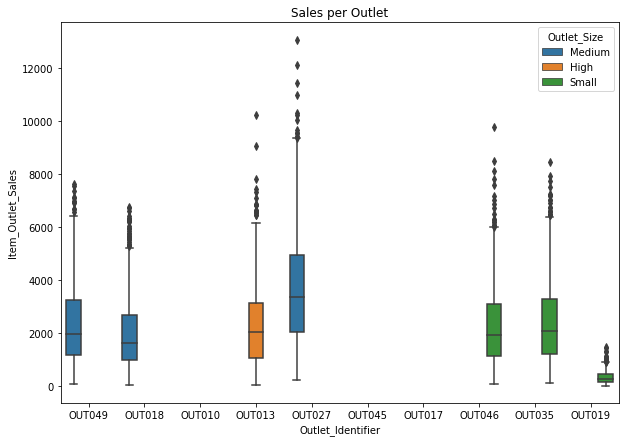

In [8]:
plt.figure(figsize=(10,7))
plt.title("Sales per Outlet")
sns.boxplot(x='Outlet_Identifier', y='Item_Outlet_Sales', data = Descriptor.df, hue='Outlet_Size')

We can note at the right of the graph that small sized outlets tend to have item sales limited to 10 000.

# Building a decision tree to score outlet size

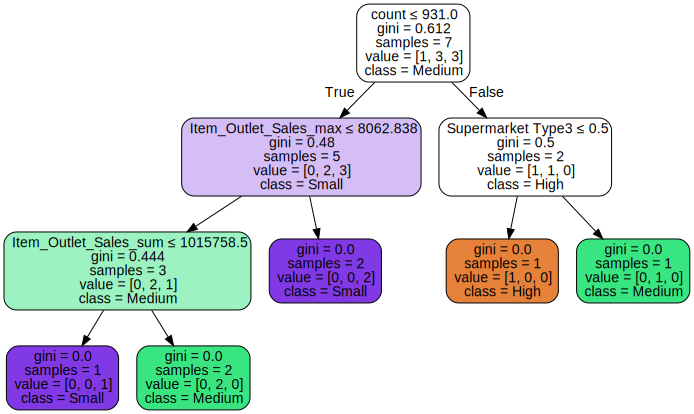

In [9]:
# aggregating Outlet criteria
X         = Descriptor.df.groupby(['Outlet_Identifier','Outlet_Size']).agg({'Item_Identifier':['count'],'Item_Outlet_Sales':['max','sum'],'Outlet_Type':['max']}).sort_values(('Item_Outlet_Sales','max')).reset_index()
XF        = Descriptor.df.groupby(['Outlet_Identifier']).agg({'Item_Identifier':['count'],'Item_Outlet_Sales':['max','sum'],'Outlet_Type':['max']}).sort_values(('Item_Outlet_Sales','max')).reset_index()
X         = pandas.concat([pandas.get_dummies(X.Outlet_Type),X],1)
XF        = pandas.concat([pandas.get_dummies(XF.Outlet_Type),XF],1)

#renaming columns
X.columns = ['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3',u'Outlet_Identifier',u'Outlet_Size',u'Item_Outlet_Sales_max',u'Item_Outlet_Sales_sum',u'Outlet_Type',u'count']
XF.columns = ['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3',u'Outlet_Identifier',u'Item_Outlet_Sales_max',u'Item_Outlet_Sales_sum',u'Outlet_Type',u'count']

#sorting columns to fit decision graph
X         = X.sort_values('Outlet_Size')
#using sklearn decision tree classifier with default converging values
OUTclf    = tree.DecisionTreeClassifier(random_state=42)
OUTclf    = OUTclf.fit(X.drop(['Outlet_Identifier','Outlet_Size','Outlet_Type'],1), X.Outlet_Size)
#predicting outlet sizes
XF['size'] = OUTclf.predict(XF.drop(['Outlet_Identifier','Outlet_Type'],1))
size_converter = XF[['size','Outlet_Identifier']].set_index('Outlet_Identifier').to_dict()['size']

#filling null values
Descriptor.df.Outlet_Size = Descriptor.df.apply(lambda x : x.Outlet_Size if str(x.Outlet_Size) != 'nan' else size_converter[x.Outlet_Identifier],1)

#plotting decision trees
dot_data = tree.export_graphviz(OUTclf, out_file=None, 
                         feature_names=X.drop(['Outlet_Identifier','Outlet_Size','Outlet_Type'],1).columns,  
                         class_names=OUTclf.classes_,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph    = graphviz.Source(dot_data)  
graph 


In this study Outlets are divided into 2 main parts :

      1.Outlets selling more than 931 different items :
        -They are considered as High sized if they belong to the group of  supermarkets typed 3
        -They are considered as Medium sized if they belong to other types of supermarket(1 and 2)
        
        
      2.Outlets selling less than 931 different items
        -They are small ones in 2 cases:
            a) if total items sold is smaller than 1015758 
            b) if less than 728 different items are sold in the outlet
        -They are considered as Medim sized if total items sold is greater than 1015758

In [10]:
#checking remaining null values
Descriptor.null_cols()

No Variables Found


[]

# Adding a few other variables

In [11]:
mapping_dict  = {'Outlet_Location_Type_num':{'Tier 1':0., 'Tier 3':2, 'Tier 2':1},'Outlet_Size_num' :{'Small':0.,'Medium':1,'High':2},'Item_Fat_Content':{'regular':'reg','low fat':'lf'},'Item_Fat_Content_num':{'reg':1.,'lf':0},'Outlet_Type_num':{ 'Grocery Store' : 0.,'Supermarket Type1' : 1, 'Supermarket Type2' : 2, 'Supermarket Type3' : 3}}
ref_year      = 2018
Descriptor.df = Descriptor.df.assign( anciennete               = lambda df : ref_year - df.Outlet_Establishment_Year
                                     ,Outlet_Size_num          = lambda df : df.Outlet_Size.replace(                             mapping_dict['Outlet_Size_num'])
                                     ,Item_Fat_Content         = lambda df : df.Item_Fat_Content.str.lower().str.strip().replace(mapping_dict['Item_Fat_Content'])
                                     ,Item_Fat_Content_num     = lambda df : df.Item_Fat_Content.str.lower().str.strip().replace(mapping_dict['Item_Fat_Content']).map(mapping_dict['Item_Fat_Content_num'])
                                     ,Outlet_Type_num          = lambda df : df.Outlet_Type.replace(                             mapping_dict['Outlet_Type_num'])
                                     ,Outlet_Location_Type_num = lambda df : df.Outlet_Location_Type.replace(                    mapping_dict['Outlet_Location_Type_num'])).dropna()
Descriptor.null_cols()

No Variables Found


[]

### TAKING A CLOSER LOOK AT NUMERIC DATA

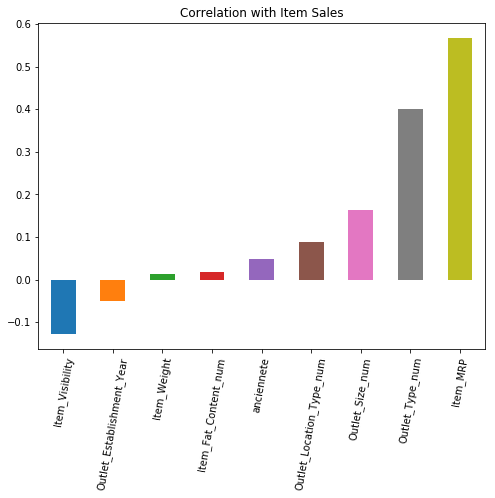

In [12]:
Descriptor.df.corr()['Item_Outlet_Sales'].sort_values().drop('Item_Outlet_Sales').plot(kind = 'bar',figsize = (8,6),rot=80,title = 'Correlation with Item Sales')

With a correlation of almost 60% the Item price seems to be the most important variable in predecting the item outlet sales

The third most correlated variable is related to the size of Outlets. The bigger the outlet the easier items get sold.

## SEARCHING FOR MULTI-COLINEARITY AND USELESS INFORMATION

In [13]:
Descriptor.df.corr().style.background_gradient().set_precision(2) # 2 non zero decimals

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_num,Outlet_Location_Type_num,Outlet_Size_num,Outlet_Type_num,anciennete
Item_Weight,1,-0.0092,0.026,-0.013,0.013,-0.027,0.0029,0.012,0.0005,0.013
Item_Visibility,-0.0092,1,-0.0013,-0.075,-0.13,0.047,-0.028,-0.094,-0.17,0.075
Item_MRP,0.026,-0.0013,1,0.005,0.57,0.0061,0.00023,-0.00087,-0.002,-0.005
Outlet_Establishment_Year,-0.013,-0.075,0.005,1,-0.049,0.0032,-0.089,-0.43,-0.12,-1
Item_Outlet_Sales,0.013,-0.13,0.57,-0.049,1,0.019,0.089,0.16,0.4,0.049
Item_Fat_Content_num,-0.027,0.047,0.0061,0.0032,0.019,1,-0.0016,0.0013,0.0022,-0.0032
Outlet_Location_Type_num,0.0029,-0.028,0.00023,-0.089,0.089,-0.0016,1,0.48,0.47,0.089
Outlet_Size_num,0.012,-0.094,-0.00087,-0.43,0.16,0.0013,0.48,1,0.4,0.43
Outlet_Type_num,0.0005,-0.17,-0.002,-0.12,0.4,0.0022,0.47,0.4,1,0.12
anciennete,0.013,0.075,-0.005,-1,0.049,-0.0032,0.089,0.43,0.12,1


Appart from variables 'anciennete'or 'Outlet_Establishment_Year', There seem not to be any anomaly related to link between predictors and all variables seem to carry a specific type of information as far as predicting sales is concerned

### * PAIR-PLOTTING VARIABLES*

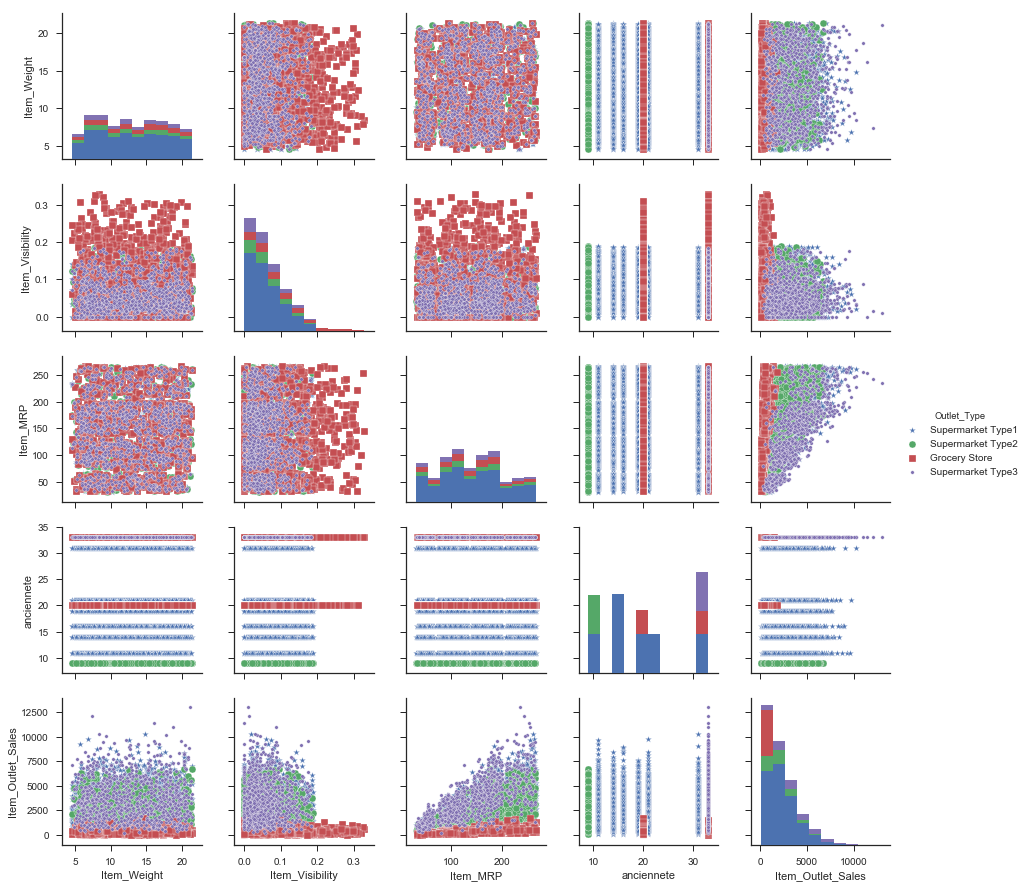

In [14]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(Descriptor.df[['Item_Weight','Item_Visibility','Item_MRP','anciennete','Item_Outlet_Sales','Outlet_Type']], hue="Outlet_Type", markers=["*","o", "s", "."])

At the second bottom right graph we can see in red that Item_visibility is mainly greater than 0.2 in grocery stores

Typed 2 supermarkets are new ones(bottom left)

# SKLEARN PIPELINE
--------------------------------
We will use sklearn pipleline and FeatureUnion modules to build a pipeline that will output required data format for prediction

In [15]:
scale_dict = Descriptor.df.agg(['std','mean']).to_dict()

class Prepare_DF(BaseEstimator, TransformerMixin):
    def __init__(self, to_quantalize)    : self.to_quantalize = to_quantalize;
    def fit(self, X, y=None)  : return self ;
    def transform(self, X) :
        df                 = X
        def fill_weight(df):
            #previously created weights
            df             = df.assign(Item_Weight = lambda df : df.apply(lambda x : x.Item_Weight if np.isnan(x.Item_Weight) == False else filler[x.Item_Identifier],1))
            df.Item_Weight = df.Item_Weight.fillna(11)
            return df
        def fill_Outlet_Size(df):
            size_converter = {'OUT010': 'Small','OUT013': 'High','OUT017': 'Small','OUT018': 'Medium','OUT019': 'Small','OUT027': 'Medium','OUT035': 'Small','OUT045': 'Small','OUT046': 'Small','OUT049': 'Medium'}
            df.Outlet_Size = df.apply(lambda x : x.Outlet_Size if str(x.Outlet_Size) != 'nan' else size_converter[x.Outlet_Identifier],1)
            return         df

        def Add_num_vars(df):
            mapping_dict              = {'Outlet_Location_Type_num':{'Tier 1':0., 'Tier 3':2, 'Tier 2':1},'Outlet_Size_num' :{'Small':0.,'Medium':1,'High':2},'Item_Fat_Content':{'regular':'reg','low fat':'lf'},'Item_Fat_Content_num':{'reg':1.,'lf':0},'Outlet_Type_num':{ 'Grocery Store' : 0.,'Supermarket Type1' : 1, 'Supermarket Type2' : 2, 'Supermarket Type3' : 3}}
            ref_year                  = 2018# could use 2013 too
            df                        = df.assign( anciennete               = lambda df : ref_year - df.Outlet_Establishment_Year,Outlet_Size_num          = lambda df : df.Outlet_Size.replace(                             mapping_dict['Outlet_Size_num']),Item_Fat_Content         = lambda df : df.Item_Fat_Content.str.lower().str.strip().replace(mapping_dict['Item_Fat_Content']),Item_Fat_Content_num     = lambda df : df.Item_Fat_Content.str.lower().str.strip().replace(mapping_dict['Item_Fat_Content']).map(mapping_dict['Item_Fat_Content_num']),Outlet_Type_num          = lambda df : df.Outlet_Type.replace(                             mapping_dict['Outlet_Type_num']),Outlet_Location_Type_num = lambda df : df.Outlet_Location_Type.replace(                    mapping_dict['Outlet_Location_Type_num'])).dropna()
            return df
        def Quantaliser(df):
            for c in self.to_quantalize    : df['quantalized_{}'.format(c)] = pandas.qcut(df[c],5).astype(str)
            return df
        return Quantaliser(Add_num_vars(fill_Outlet_Size(fill_weight(df))))

# Creating a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names) : self.attribute_names = attribute_names;
        
    def fit(self, X, y=None)            : return self;
    
    def transform(self, X)              : return X[self.attribute_names];

# Creating dummy variables
class GetDummies(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None)            : return self;
    
    def transform(self, X)              : return pandas.get_dummies(X);
# Creating polynomial features
class PolynomialFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,poly,degrees)     : self.poly,self.degrees=poly,degrees;
    
    def fit(self, X, y=None)            : return self;
    
    def transform(self, X)              : 
        for col in self.poly : 
            for i in range(2,self.degrees+1) : X[col+'_{}'.format(i)] = X[col].pow(i)
        return X;
class StandardScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self,to_scale)         : self.to_scale=to_scale;
    
    def fit(self, X, y=None)            : return self;
    
    def transform(self, X)              : 
        def scale(c,x)                  : return (x-scale_dict[c]['mean'])/scale_dict[c]['std']
        for c in self.to_scale          : X[c] = X[c].apply(lambda x : scale(c,x),1)
        return X;

In [16]:
#defining the category of variables  
# we will use n_job = -1 to use all available cores in computer and get faster computation
dummy_attribs   = ['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type','quantalized_Item_Weight','quantalized_Item_Visibility','quantalized_Item_MRP']
poly_attribs    = ['Item_Weight','Item_Visibility','Item_MRP',]
to_quantalize   = ['Item_Weight','Item_Visibility','Item_MRP','anciennete']
added_variables = ['Item_Fat_Content_num','Outlet_Location_Type_num','Outlet_Size_num','Outlet_Type_num']

catpipe         = Pipeline([('prep',Prepare_DF(to_quantalize=to_quantalize)),('selector',   DataFrameSelector(dummy_attribs)),('GetDummies', GetDummies())])
numpipe         = Pipeline([('prep',Prepare_DF(to_quantalize=to_quantalize)),('selector',   DataFrameSelector(poly_attribs)),('poly',PolynomialFeatures(poly=poly_attribs,degrees=5)),('scale', StandardScaler(to_scale=poly_attribs))])
extrapipe       = Pipeline([('prep',Prepare_DF(to_quantalize=to_quantalize)),('selector',   DataFrameSelector(added_variables))])

full_pipe       = FeatureUnion(transformer_list=[('num_pipeline', numpipe),('cat_pipeline', catpipe),('extra'  ,extrapipe)],n_jobs=-1) #to user all cores

full_train      = full_pipe.fit_transform(Descriptor.df)
full_test       = full_pipe.fit_transform(testdf)

In [17]:
full_test.shape,full_train.shape

((5681, 72), (8523, 72))

# STRATIFIED EVALUATION SET

We need to evaluate our model before submission in order to see how well it does.

In order to do so we will rely on stratified train-test splitting that will allow us to have significant test sets.

We will make sure that in both the evaluation set and the training set we have the same distribution of the Maximum 
retail price variable which seems to be best predictor.


In [18]:
#we will use numpy ceil function of X which will allow us to have the smallest integer I such as I>=X
Price_cat           = np.ceil(Descriptor.df.Item_MRP/60)
Price_cat.value_counts()

3.0    2623
2.0    2337
4.0    1766
1.0    1141
5.0     656
Name: Item_MRP, dtype: int64

In [19]:
# we will set random_state=42 to ensure reproducibility and size to 10%

split                             = StratifiedShuffleSplit(n_splits=1, test_size=0.10,random_state=42)
for train_index, test_index in split.split(full_train, Price_cat):
    strat_train_set,y_train_strat = full_train[train_index,:],Descriptor.df.Item_Outlet_Sales[train_index]
    strat_test_set,y_test_strat   = full_train[test_index,:],Descriptor.df.Item_Outlet_Sales[test_index]

In [20]:
print strat_train_set.shape,y_train_strat.shape
print strat_test_set.shape,y_test_strat.shape

(7670, 72) (7670,)
(853, 72) (853,)


# Randomn Forest Regressor
*Hyperparameters tuning*

In [21]:
#defining a grid of parameters
param_grid  = {"max_depth": [1,None],"min_samples_leaf": [1,15],"n_estimators":[100,300,1000],"n_jobs":[2]}

RF          = RandomForestRegressor()

# running grid search (this may take a while to compute)
#RF = GridSearchCV(LF, param_grid=param_grid, cv=5) #cv = 5 enable 5-folds crosss-validation
#RF.fit(strat_train_set,y_train_strat)
#RF.best_estimator_

RF          = RandomForestRegressor(
    bootstrap=True, criterion='mse', max_depth=None,
    max_features='auto', max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=15, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
    oob_score=False, random_state=None, verbose=0, warm_start=False
)
RF.fit(strat_train_set,y_train_strat)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

We will now use features importance in order to update arrays iteratively and remove useless variables


In [22]:

# FIRST EPOCH
to_del     = pandas.Series(RF.feature_importances_).sort_values()[:11]
print('lowest importance',to_del.round(10).to_dict())

def UpdateArray(array,to_del) : return np.delete(array,to_del,axis=1)
    
strat_train_set = UpdateArray(strat_train_set,to_del.keys())
strat_test_set  = UpdateArray(strat_test_set,to_del.keys())
full_train      = UpdateArray(full_train,to_del.keys())
full_test       = UpdateArray(full_test,to_del.keys())

#SECOND EPOCH
RF.fit(strat_train_set,y_train_strat)
print('rmse',np.sqrt(mean_squared_error(y_test_strat,RF.predict(strat_test_set))))

to_del     = pandas.Series(RF.feature_importances_).sort_values()[:3]
print('lowest importance',to_del.to_dict())


    
strat_train_set = UpdateArray(strat_train_set,to_del.keys())
strat_test_set  = UpdateArray(strat_test_set,to_del.keys())
full_train      = UpdateArray(full_train,to_del.keys())
full_test       = UpdateArray(full_test,to_del.keys())

RF.fit(strat_train_set,y_train_strat)
print('rmse',np.sqrt(mean_squared_error(y_test_strat,RF.predict(strat_test_set))))



('lowest importance', {64: 2.82815e-05, 33: 5.1073e-06, 66: 3.5818e-06, 37: 6.0116e-06, 65: 8.5984e-06, 18: 2.69166e-05, 19: 0.0, 24: 9.2403e-06, 28: 0.0, 29: 0.0, 62: 3.47321e-05})
('rmse', 1146.52405635104)
('lowest importance', {56: 2.1324448941865872e-05, 49: 5.980858631505167e-05, 55: 2.0530980548581426e-05})
('rmse', 1145.4427370615713)


### Randomn forest on log value of sales



In [23]:
LRF          = RandomForestRegressor(
    bootstrap=True, criterion='mse', max_depth=7,
    max_features='auto', max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
    oob_score=False, random_state=42, verbose=0, warm_start=False
)
LRF.fit(strat_train_set,np.log(y_train_strat))

print('rmse',np.sqrt(mean_squared_error(y_test_strat,np.exp(LRF.predict(strat_test_set)))))



('rmse', 1175.7989929989787)


# XGboost 
*Extreme gradient boosting*

In [ ]:
xgb_params = { 'objective': 'reg:linear','nthread': 1,'alpha':1,'eval_metric' : 'rmse','eta':0.0007,'n_estimators':100}
num_round  = 5724
dtrain     = xgb.DMatrix(data=strat_train_set,label=y_train_strat)
deval      = xgb.DMatrix(data=strat_test_set,label=y_test_strat)
evallist   = [(deval, 'eval'), (dtrain, 'train')]
plst       = xgb_params.items()
bst         = xgb.train(plst,dtrainf,num_round, evallist)



# Submission

In [ ]:

dtrainf     = xgb.DMatrix(data=full_train,label=Descriptor.df.Item_Outlet_Sales)
RF          = RF.fit(full_train,Descriptor.df.Item_Outlet_Sales)

submitxgb   = submit.copy()
submitxgb['Item_Outlet_Sales'] = bst.predict(xgb.DMatrix(full_test))

submitRF   = submit.copy()
submitRF['Item_Outlet_Sales'] = RF.predict(full_test)

#adding mean of values
submitM   = submit.copy()
submitM['Item_Outlet_Sales'] = (RF.predict(full_test)+bst.predict(xgb.DMatrix(full_test)))/2







In [32]:
submitxgb.Item_Outlet_Sales = submitxgb.Item_Outlet_Sales.round().astype(int)
submitRF.Item_Outlet_Sales = submitRF.Item_Outlet_Sales.round().astype(int)
submitM.Item_Outlet_Sales = submitM.Item_Outlet_Sales.round().astype(int)

submitxgb.to_csv('xgb.csv',index = None)
submitRF.to_csv('RF.csv',index = None)
submitM.to_csv('M.csv',index = None)


In [ ]:
strat_train_set.shape

In [ ]:
full_test.shape

In [ ]:
submit.shape